### Trabajo Práctico Final - ERV 
4to bimestre 2023

## Detección de fallas en neumáticos utilizando los descriptores HOG y LBP
**Alumno:** Manuel García Tornadú
**Profesores:** María Elena Buemi - Daniel Acevedo - Pablo Negri  




### Introducción
La detección de fallas en los neumáticos es un problema de gran importancia para la industria, ya que puede mejorar la calidad de producción, pero también al ser una de las partes más importantes de los automóbiles, mejorar o verificar la calidad de su superficie es indispensable porque afecta directamente la seguridad de los usuarios.  

La idea del trabajo es replicar los procedimientos para la detección de fallas en neumáticos usados en el paper **"Tire appearance defect detection method via combining HOG and LBP features"** escrito por Hongbin Liu, Xinghao Jia, Chenhui Su, Hongjuan Yang and Chengdong Li.  

En el mismo proponen un método para la detección de fallas usando los descriptores HOG y LBP de las imágenes para clasificarlas con SVM.   Muestran que se logra una mejora en la exactitud de las predicciones fusionando la clasificación hecha con cada uno de esos descriptores por separado.  

En el siguiente trabajo intentamos replicar todos los pasos descriptos para poder obtener resultados similares a los del paper original.


In [2]:
# Librerías usadas
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import random
from IPython.display import display

## Procesamiento de imágenes

Contamos con un dataset ([link dataset](https://www.kaggle.com/datasets/jehanbhathena/tire-texture-image-recognition)) que consta en total de 1028 imágenes cuadradas y en color, de las cuales 537 son fotos de neumáticos fallados y 491 sin fallas.

El dataset viene separado originalmente en dos grupos para entrenamiento y test, la cantidad de fotos para test es aproximadamente del 30 % del total.



In [3]:
#carpetas de ubicación del dataset
carpeta_entrenamiento_normal = Path('./training_data/normal')
carpeta_entrenamiento_cracked = Path('./training_data/cracked')
carpeta_test_normal = Path('./testing_data/normal')
carpeta_test_cracked = Path('./testing_data/cracked')

#### Algunas muestras del dataset:

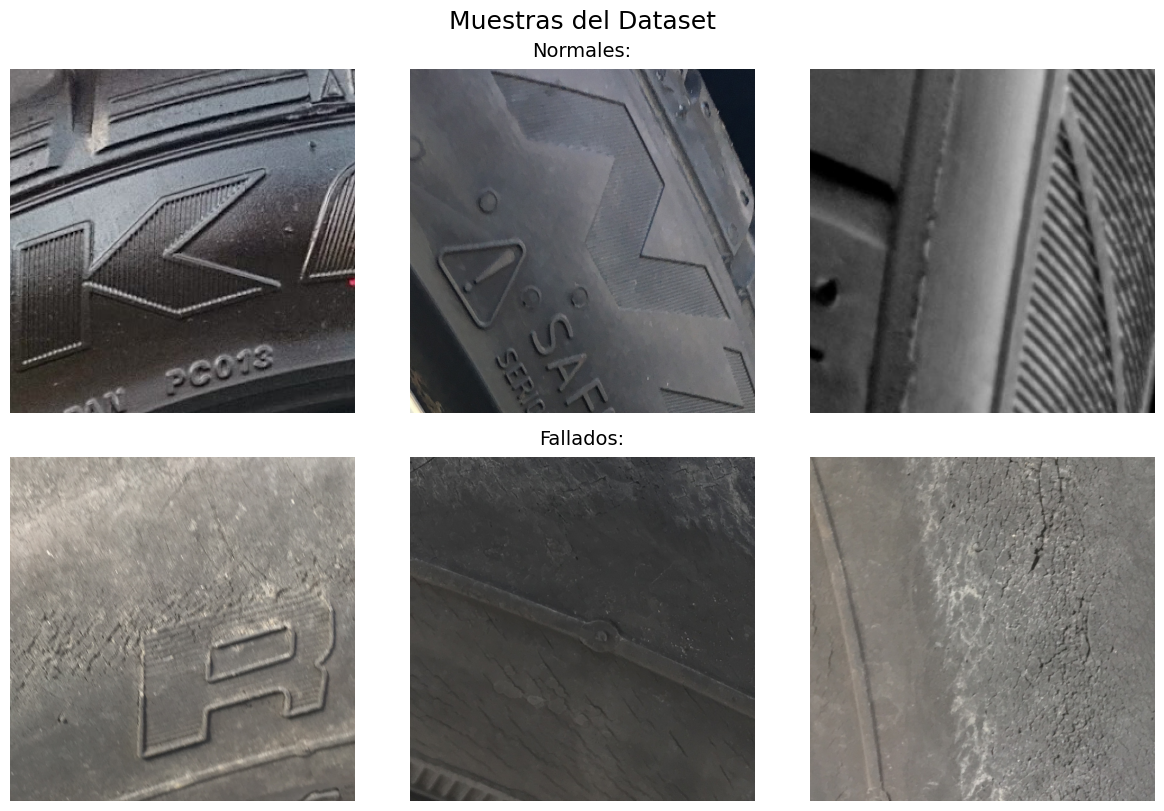

In [4]:
lista_normales = list(carpeta_entrenamiento_normal.glob(r"*.jpg"))
lista_falladas = list(carpeta_test_cracked.glob(r"*.jpg"))

fig = plt.figure(constrained_layout=True, figsize=(12, 8))
fig.suptitle('Muestras del Dataset', size=18)

subfigs = fig.subfigures(nrows=2, ncols=1)

subfigs[0].suptitle('Normales:', size=14)
subfigs[1].suptitle('Fallados:', size=14)

axs = subfigs[0].subplots(nrows=1, ncols=3)
for ax in axs.flat:
    imagen = np.array(Image.open(random.choice(lista_normales)))
    ax.axis('off')
    ax.imshow(imagen)

axs = subfigs[1].subplots(nrows=1, ncols=3)
for ax in axs.flat:
    imagen = np.array(Image.open(random.choice(lista_falladas)))
    ax.axis('off')
    ax.imshow(imagen)


#### Funciones para el procesamiento de imágenes:

El paper propone hacer un procesamiento previo de las imágenes para obtener mejores resultados y rendimientos computacionales.  

Primero las lleva a escala de gris con una formula que pondera con distintos coeficientes cada canal RGB de la imagen original, la fórmula es la siguiente:  
$$ I(x, y) = 0.299 \cdot R(x, y) + 0.587 \cdot G(x, y) + 0.144 \cdot B(x, y)$$
 

Luego normaliza el tamaño de las imágenes a 64 x 64 pixels usando una interpolación bilineal.  

A continuación replicamos esos pasos:

In [16]:
#Cambia la imagen a escala de grises con los parámteros que se usan en el paper
def pasa_a_escala_de_gris(imagen):
    img = np.array(imagen)
    return np.int8(img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.144)


# Modifica el tamaño de la imagen usando el método de interpolación bilinear usado en el paper
def cambia_dimension(imagen, dimension):
    imagen_escalada = imagen.resize((dimension, dimension), Image.BILINEAR)
    return imagen_escalada


# Procesa toda una carpeta de imagenes: las pasa a escala de gris y luego reduce el tamaño al pasado por parámetro.
# Guarda las imagenes en una carpeta y devuelve la ruta de la misma
def procesa_imagenes(carpeta, dim):
    lista_nombres = list(carpeta.glob(r"*.jpg"))
    nombre_carpeta = "procesados_" + str(dim)
    carpeta_procesados = carpeta / nombre_carpeta
    carpeta_procesados.mkdir(exist_ok=True)
    i = 0
    for ruta_imagen in lista_nombres:
        img = Image.open(ruta_imagen)
        if img.mode != 'L':
            imagen_array = pasa_a_escala_de_gris(img)
            imagen_escalada = cambia_dimension(Image.fromarray(imagen_array, 'L'), dim)
        else:
            imagen_escalada = cambia_dimension(img, dim)
        nombre_archivo = "imagen_" + str(i) + ".png"
        imagen_escalada.save(carpeta_procesados / nombre_archivo)
        i += 1
    return carpeta_procesados



In [17]:
# Procesar imagenes:
# (Esto está comentado para no volver a procesar todas las imágenes de vuelta por error):

# carpeta_entrenamiento_normal_procesados = procesa_imagenes(carpeta_entrenamiento_normal, 64)
# carpeta_entrenamiento_cracked_procesados = procesa_imagenes(carpeta_entrenamiento_cracked, 64)
# carpeta_test_normal_procesados = procesa_imagenes(carpeta_test_normal, 64)
# carpeta_test_cracked_procesados = procesa_imagenes(carpeta_test_cracked, 64)

In [18]:
# Carpetas con imagenes ya procesadas:
entrenamiento_normal_procesados = Path('./training_data/normal/procesados_64')
entrenamiento_cracked_procesados = Path('./training_data/cracked/procesados_64')
test_normal_procesados = Path('./testing_data/normal/procesados_64')
test_cracked_procesados = Path('./testing_data/cracked/procesados_64')

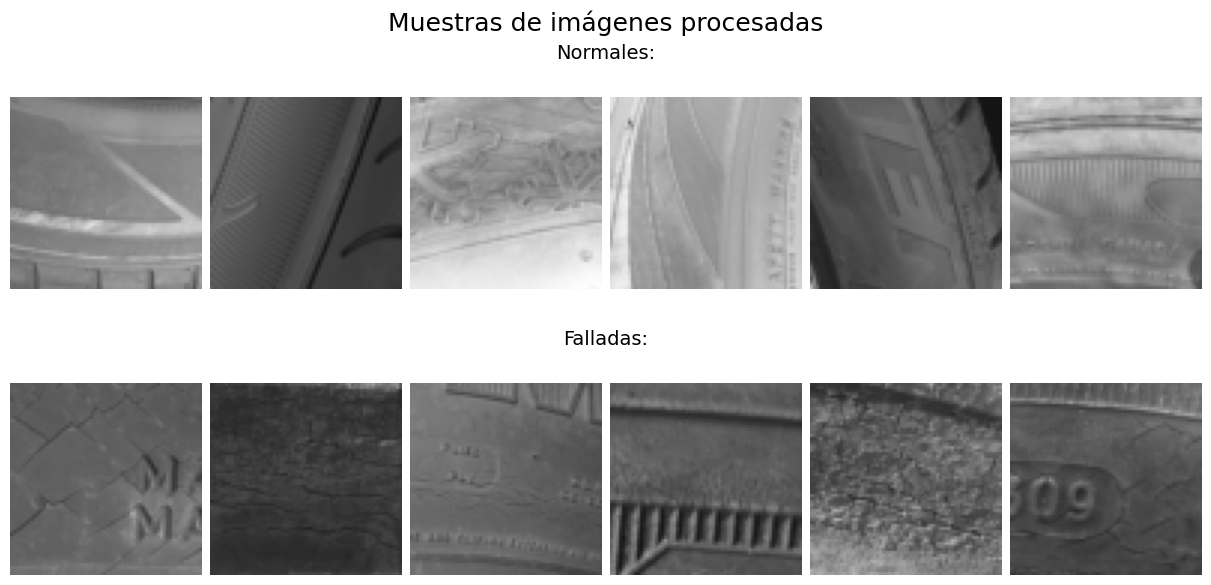

In [19]:
lista_normales = list(entrenamiento_normal_procesados.glob(r"*.png"))
lista_falladas = list(entrenamiento_cracked_procesados.glob(r"*.png"))

fig = plt.figure(constrained_layout=True, figsize=(12, 6))
fig.suptitle('Muestras de imágenes procesadas', size=18)

subfigs = fig.subfigures(nrows=2, ncols=1)

subfigs[0].suptitle('Normales:', size=14)
subfigs[1].suptitle('Falladas:', size=14)

axs = subfigs[0].subplots(nrows=1, ncols=6)
for ax in axs.flat:
    imagen = np.array(Image.open(random.choice(lista_normales)))
    ax.axis('off')
    ax.imshow(imagen, cmap='gray', vmin=0, vmax=255)

axs = subfigs[1].subplots(nrows=1, ncols=6)
for ax in axs.flat:
    imagen = np.array(Image.open(random.choice(lista_falladas)))
    ax.axis('off')
    ax.imshow(imagen, cmap='gray', vmin=0, vmax=255)


## Armado de datasets para entrenamiento y test

En principio vamos a respetar la separación entre datos de entrenamiento y test que viene dada con el dataset, dijimos que el tamaño del conjunto de fotos para test es de alrededor del 30%.  

Sin embargo el paper toma aleatoriamente un conjunto para test del 20% del total repetidas veces para obtener un promedio de la exactitud del método, cosa que vamos a hacer luego.

In [20]:
def arma_dataset(normales, falladas):
    lista_normales = list(normales.glob(r"*.png"))
    # etiqueta normal = 0
    etiquetas_normales = np.zeros(len(lista_normales))

    lista_falladas = list(falladas.glob(r"*.png"))
    # etiqueta fallada = 1
    etiquetas_falladas = np.ones(len(lista_falladas))

    data_normales = pd.concat(
        [pd.Series(lista_normales, name='nombre'), pd.Series(etiquetas_normales, name='etiqueta')], axis=1)
    data_falladas = pd.concat(
        [pd.Series(lista_falladas, name='nombre'), pd.Series(etiquetas_falladas, name='etiqueta')], axis=1)

    data = pd.concat([data_normales, data_falladas], ignore_index=True)
    # Cambio el orden
    data = data.sample(frac=1, ignore_index=True)
    return data


In [21]:
data_entrenamiento = arma_dataset(entrenamiento_normal_procesados, entrenamiento_cracked_procesados)
data_test = arma_dataset(test_normal_procesados, test_cracked_procesados)

## Descriptor HOG

El primer descriptor que usa es el HOG, o histograma de gradientes, se basa en dividir la imagen en celdas y tomar el histograma de los vectores gradiente en los pixels de la celda.  
 
En cada pixel hay un vector gradiente que se calcula con sus pixeles vecinos de la siguiente manera:  
$$ G_{x}(x, y) = H(x + 1, y) - H(x - 1, y) $$
$$ G_{y}(x, y) = H(x, y + 1) - H(x, y - 1) $$

Luego se calcula la norma con la norma euclidiana o norma 2

Por cada celda de la imagen hay un histograma que tiene 9 bins que representan saltos de 20º en la dirección de los gradientes. La amplitud de los vectores gradiente es la que suma al valor del histograma en cada bin.  

Luego se toman bloques de celdas para juntar sus histogramas, normalizarlos y empaquetar toda esta información en un vector de features que representa toda la imagen.  

El paper especifica el valor de los 9 bins del histograma (saltos de 20º) pero no especifica el tamaño de celda ni de bloque, yo tomo en principio, un tamaño de celda de 8 x 8 pixels y bloques de 2 x 2 celdas, dando como resultado vectores de features de dimensión 1764.
    
Luego, hacia el final, modifico el tamaño de celda para evaluar la diferencia en exactituda del método. 

### Extracción del descriptor HOG

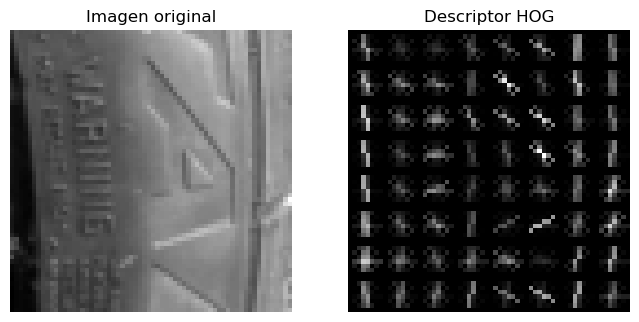

In [23]:
lista_nombres = list(entrenamiento_normal_procesados.glob(r"*.png"))
img = Image.open(lista_nombres[21])

fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), block_norm='L2', transform_sqrt=True, visualize=True)

_ , (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.axis('off')
ax1.imshow(img, cmap='gray')
ax1.set_title('Imagen original')

ax2.axis('off')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('Descriptor HOG')
plt.show()

### Matriz de features HOG y vector target

In [26]:
# Función para calcular para una imagen, su vector de features HOG
def vectorHOG(imagen, celda, bloque):
    resultado = hog(imagen, orientations=9, pixels_per_cell=(celda, celda),
                    cells_per_block=(bloque, bloque), block_norm='L2', transform_sqrt=True)
    return resultado


In [27]:
# Función para calcular, dado un dataset, toda la matriz de features HOG y el vector target
def matrizHOG(dataset, celda=8, bloque=2):
    y = dataset['etiqueta'].to_numpy()
    cantidad = dataset['nombre'].size
    imagen = Image.open(dataset['nombre'][0])
    hogCero = vectorHOG(imagen, celda, bloque)
    X = np.zeros((cantidad, hogCero.size))
    X[0, :] = hogCero
    for i in range(1, cantidad):
        imagen = Image.open(dataset['nombre'][i])
        hog_i = vectorHOG(imagen, celda, bloque)
        X[i, :] = hog_i
    return (X, y)



Preparamos los datos para la clasificación con SVM:

In [28]:
X_train_hog, y_train_hog = matrizHOG(data_entrenamiento, 8, 2)
X_test_hog, y_test_hog = matrizHOG(data_test, 8, 2)

### Clasificación HOG + SVM

El paper propone probar diferentes kernels para la clasificación con SVM, menciona tres opciones que están implementadas en la libería sklearn.svm que vamos a usar:  
 
El kernel lineal, el polinomial con la opción de elegir distintos grados y el rbf o _radial basis kernel function_  

Para la clasificación con el descriptor HOG, el que mejor resultado nos dió fue el polinomial con grado 1, así que nos quedamos con ese.

In [29]:
# función para calcular el accuracy de la predicción de neumáticos fallados
def calcula_score(prediccion, datos_reales):
    prediccion_fallados = np.array(prediccion >= 0.5)
    correctos = sum(np.array(prediccion_fallados == datos_reales))

    return correctos / np.size(datos_reales)


#### Prueba de los diferentes kernels de SVM:

In [30]:
# kernel lineal

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='linear', degree=3, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel lineal): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel lineal): 0.6153846153846154


In [31]:
# kernel polinomial grado 1

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='poly', degree=1, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel polinomial grado 1): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel polinomial grado 1): 0.676923076923077


In [32]:
# kernel polinomial grado 2

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='poly', degree=2, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel polinomial grado 2): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel polinomial grado 2): 0.6615384615384615


In [33]:
# kernel polinomial grado 3

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='poly', degree=3, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel polinomial grado 3): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel polinomial grado 3): 0.6553846153846153


In [34]:
# kernel RBF

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='rbf', degree=2, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel RBF): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel RBF): 0.6492307692307693


El kernel que mejor resultado dió es el polinomial de grado 1

## Descriptor LBP

El otro descriptor usado es el LBP o _Local Binary Pattern_ que etiqueta los pixels de una imagen mediante el umbral en la vecindad de cada pixel y da como resultado un número binario.  

En este caso el paper especifica mirar una vecindad de 8 pixels, que es equivalente a mirar los 8 pixels que rodean un pixel en una celda de 3 x 3.  

Para obtener este resultado uso la librería skimage.feature pasando por parámetro (P) = 8 y radio (R) = 1  

Entonces cada pixel de la imagen tiene definido un valor binario de valor máximo 2<sup>8</sup> = 256  

Similarmente al caso de HOG, dividimos la imagen en celdas y calculamos histogramas para los valores incluidos en la celda, cada histograma tiene 256 bins por la cantidad de valores diferentes que podemos obtener en cada pixel.

El paper no especifica el tamaño de las celdas, uso una celda de 8 x 8 al igual que en HOG, resultando un vector de features de dimensión 16384, bastante más que con HOG.

### Extracción del descriptor LBP

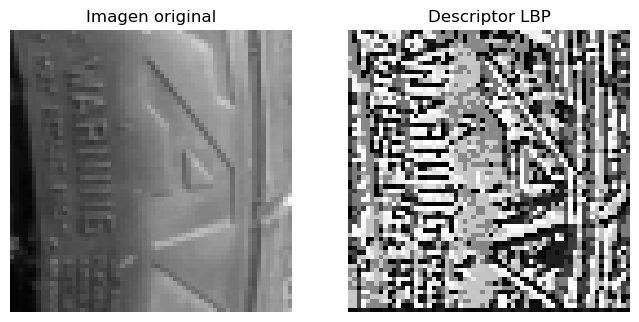

In [39]:
lista_nombres = list(entrenamiento_normal_procesados.glob(r"*.png"))
img = Image.open(lista_nombres[21])

lbp = local_binary_pattern(img, 8, 1, method='default')

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.axis('off')
ax1.imshow(img, cmap='gray')
ax1.set_title('Imagen original')

ax2.axis('off')
ax2.imshow(lbp, cmap='gray')
ax2.set_title('Descriptor LBP')
plt.show()


### Matriz de features LBP y vector target

In [40]:
# Función para calcular para una imagen, su vector de features LBP
def vectorLBP(imagen, celda):
    ancho = np.shape(imagen)[1]
    alto = np.shape(imagen)[0]
    lbp = local_binary_pattern(imagen, 8, 1, method='default')
    resultado = np.empty((0, 0))
    for i in range(0, int(alto / celda)):
        for j in range(0, int(ancho / celda)):
            histograma, _ = np.histogram(lbp[i * celda: (i + 1) * celda, j * celda:(j + 1) * celda], bins=256,
                                         range=(0, 256))
            # scaler.fit(hist)
            # scaler.transform(hist)
            normalizado = scale(histograma)
            resultado = np.append(resultado, normalizado)
    return resultado


In [41]:
# Función para calcular, dado un dataset, toda la matriz de features LBP y el vector target
def matrizLBP(dataset, celda=8, bloque=2):
    y = dataset['etiqueta'].to_numpy()
    cantidad = dataset['nombre'].size
    imagen = Image.open(dataset['nombre'][0])
    lbpCero = vectorLBP(imagen, celda)
    X = np.zeros((cantidad, lbpCero.size))
    X[0, :] = lbpCero
    for i in range(1, cantidad):
        imagen = Image.open(dataset['nombre'][i])
        lbp_i = vectorLBP(imagen, celda)
        X[i, :] = lbp_i
    return (X, y)

Preparamos los datos para la clasificación con SVM:

In [38]:
# datos de entrenamiento y test
X_train_lbp, y_train_lbp = matrizLBP(data_entrenamiento)
X_test_lbp, y_test_lbp = matrizLBP(data_test)

### Clasificación LBP + SVM

#### Prueba de los diferentes kernels de SVM:

Al igual que en el caso anterior, probamos diferentes kernels para ver cuál resulta más conveniente.

In [42]:
# kernel lineal

# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='linear', degree=2, probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel lineal): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))

 Exactitud LBP + SVM (kernel lineal): 0.7569230769230769


In [43]:
# kernel polinomial grado 2

# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='poly', degree=2, probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel polinomial grado 2): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))

 Exactitud LBP + SVM (kernel polinomial grado 2): 0.7353846153846154


In [44]:
# kernel polinomial grado 3

# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='poly', degree=3, probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel polinomial grado 3): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))

 Exactitud LBP + SVM (kernel polinomial grado 3): 0.72


In [45]:
# kernel RBF

# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='rbf', probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel RBF): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))

 Exactitud LBP + SVM (kernel RBF): 0.7292307692307692


Para la clasificación con el descriptor LBP el mejor kernel resultó ser el lineal.

## Fusión HOG + LBP + SVM

El paper propone la siguiente fórmula para la clasificación fusionando los dos clasificadores:

$$ Score = \lambda_{1} \cdot Score_{HOG} + \lambda_{2} \cdot Score_{LBP} $$

Lambda 1 y Lambda 2 son coeficientes que ponderan cada clasificador y respetan que:
$$ \lambda_{1}  + \lambda_{2}  = 1 $$


In [47]:
# Función que fusiona dos clasificaciones con distintos coeficientes
def fusion(prediccion_1, prediccion_2, coeficiente_1, coeficiente_2):
    return prediccion_1 * coeficiente_1 + prediccion_2 * coeficiente_2


Nos quedamos con los kernels que mejor resultado dieron:

In [63]:
# kernel polinomial grado 1 para HOG
# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='poly', degree=1, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel polinomial grado 1): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

# kernel lineal para LBP:
# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='linear', degree=2, probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel lineal): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))


 Exactitud HOG + SVM (kernel polinomial grado 1): 0.68
 Exactitud LBP + SVM (kernel lineal): 0.7538461538461538


In [64]:
def calcula_fusion(prediccion_1, prediccion_2, dato_real):
    resultado = np.zeros((21, 3))
    resultado[:, 1] = np.linspace(0, 1, 21)
    resultado[:, 2] = 1 - resultado[:, 1]
    for i in range(0, 21):
        score = calcula_score(fusion(prediccion_1, prediccion_2, resultado[i, 1], resultado[i, 2]), dato_real)
        resultado[i, 0] = score
    return resultado

In [65]:
tabla_fusion = calcula_fusion(y_pred_hog[:, 1], y_pred_lbp[:, 1], y_test_hog)
df_fusion = pd.DataFrame(tabla_fusion, columns=['Score', 'Lambda 1', 'Lambda 2'])

In [66]:
display(df_fusion)

,Score,Lambda 1,Lambda 2
0,0.753846,0.00,1.00
1,0.750769,0.05,0.95
2,0.750769,0.10,0.90
3,0.756923,0.15,0.85
4,0.756923,0.20,0.80
5,0.756923,0.25,0.75
6,0.747692,0.30,0.70
7,0.741538,0.35,0.65
8,0.741538,0.40,0.60
9,0.732308,0.45,0.55


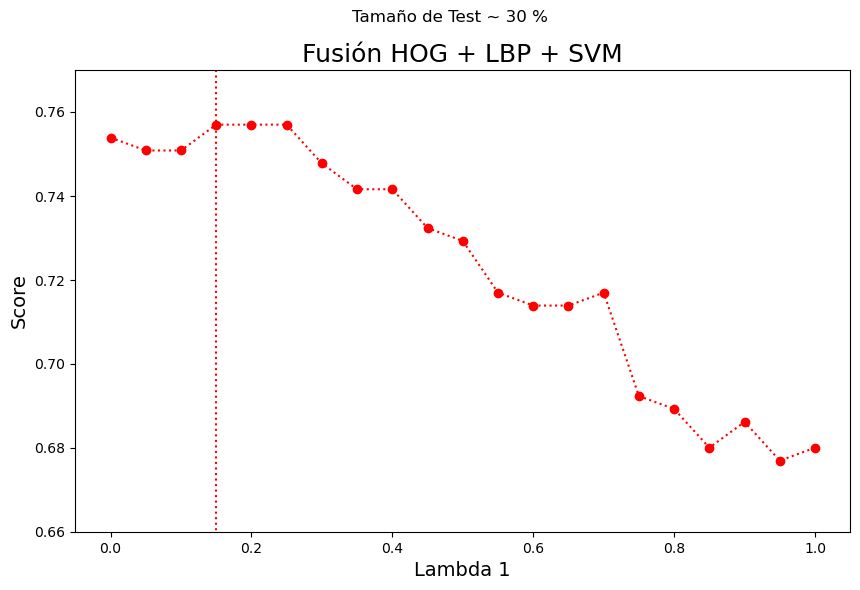

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(df_fusion["Lambda 1"], df_fusion["Score"], 'o:r')
plt.title('Fusión HOG + LBP + SVM', size=18)
plt.suptitle('Tamaño de Test ~ 30 %')

plt.ylim((0.66, 0.77))
plt.xlabel("Lambda 1", size=14)
plt.ylabel("Score", size=14)

indice_max = df_fusion['Score'].idxmax()
lambda_max = df_fusion['Lambda 1'][indice_max]
plt.vlines(lambda_max, 0.3, 0.77, linestyles='dotted', colors='red')
plt.show()


Con esta división del dataset obtenemos una exactitud menor que el paper, pero se ve la misma leve mejora cuando fusionamos las dos clasificaciones.  

La clasificación LBP resulta más exacta que la HOG, pero fusionando ambas, con el coeficiente Lambda 1 entre 0.15 y 0.25 (es decir tomando mayoritariamente la clasificación LBP) obtenemos una mejora de alrededor del 0.5 % con respecto a LBP y alrededor del 10 % con respecto a HOG, es un poco menos que la obtenida en el paper y con un coeficiente Lambda 1 un poco menor (en el paper el resultado óptimo se da con lambda 1 = 0.3)

## Clasificación variando los conjuntos Test y Entrenamiento
El paper propone separar aleatoriamente un 20 % de los datos para testear el modelo. Hasta ahora respetamos la división como venía dada en el dataset (~30 %), voy a replicar lo que se hace en el paper.  

Se define un 20 % del total, unas 206 fotografías para test y el resto (822) para entrenamiento.  
Esto se repite unas 10 veces, se calcula el _accuracy_ cada vez y luego se saca el promedio, este promedio nos da una idea de la exactitud del modelo.

In [68]:
dataset_total = pd.concat([data_entrenamiento, data_test], ignore_index=True)

In [69]:
X_HOG, y_HOG = matrizHOG(dataset_total, 8, 2)
X_LBP, y_LBP = matrizLBP(dataset_total)

In [70]:
def calcula_scores(X_dataset, y_dataset, cantidad=10, split=0.2, kernel='poly', grado=1):
    resultado = np.zeros(cantidad)
    for i in range(cantidad):
        X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=split, random_state=i)

        svc = SVC(kernel=kernel, degree=grado, probability=True)
        svc.fit(X_train, y_train)

        y_pred = svc.predict_proba(X_test)
        exactitud = calcula_score(y_pred[:, 1], y_test)
        print(" Exactitud " + str(i) +" : " + str(exactitud))
        resultado[i] = exactitud
    return resultado




In [71]:
resultados_HOG = calcula_scores(X_HOG, y_HOG, 10, 0.2)

 Exactitud 0 : 0.7233009708737864
 Exactitud 1 : 0.6796116504854369
 Exactitud 2 : 0.7087378640776699
 Exactitud 3 : 0.7378640776699029
 Exactitud 4 : 0.7766990291262136
 Exactitud 5 : 0.6553398058252428
 Exactitud 6 : 0.7087378640776699
 Exactitud 7 : 0.7378640776699029
 Exactitud 8 : 0.6650485436893204
 Exactitud 9 : 0.7184466019417476


In [72]:
print("Promedio HOG + SVM : " + str(np.mean(resultados_HOG)))

Promedio HOG + SVM : 0.7111650485436893


In [73]:
resultados_LBP = calcula_scores(X_LBP, y_LBP, kernel='linear')

 Exactitud 0 : 0.8592233009708737
 Exactitud 1 : 0.8349514563106796
 Exactitud 2 : 0.8592233009708737
 Exactitud 3 : 0.8155339805825242
 Exactitud 4 : 0.8495145631067961
 Exactitud 5 : 0.8398058252427184
 Exactitud 6 : 0.8737864077669902
 Exactitud 7 : 0.8349514563106796
 Exactitud 8 : 0.8058252427184466
 Exactitud 9 : 0.8543689320388349


In [74]:
print("Promedio LBP + SVM : " + str(np.mean(resultados_LBP)))

Promedio LBP + SVM : 0.8427184466019417


Replicando el algoritmo propuesto en el paper de la división del dataset, obtuvimos resultados mucho más parecidos, aumentando significativamente la exactitud de las clasificaciones.  

Exactitud promedio paper HOG = 0.705
Exactitud promedio obtenida HOG = 0.712  

Exactitud promedio paper LBP = 0.825
Exactitud promedio obtenida LBP = 0.843  

Lo obtenido aquí es levemente superior, se puede deber a varios factores, pero uno puede ser el kernel utilizado, en el paper, en un momento mencionan que ellos eligen usar el lineal, pero no queda claro si lo usan para las dos clasificaciones, acá usamos el polinomial para HOG y el lineal para LBP.


### Fusión con tamaño de Test 20 %
Para calcular la fusión me quedo con una división arbitraria del dataset usada en el paso anterior (La número 2).  

Vemos que el rendimiento mejora levemente al igual que en el paper.

In [92]:
# Entrenamiento HOG + SVM
X_train_hog2, X_test_hog2, y_train_hog2, y_test_hog2 = train_test_split(X_HOG, y_HOG, test_size=0.2, random_state=2)

svc_hog2 = SVC(kernel='poly', degree=1, probability=True)
svc_hog2.fit(X_train_hog2, y_train_hog2)

# Predicción HOG + SVM
y_pred_hog2 = svc_hog2.predict_proba(X_test_hog2)

print(" Exactitud HOG + SVM (kernel polinomial grado 1): " + str(calcula_score(y_pred_hog2[:, 1], y_test_hog2)))

# Entrenamiento LBP + SVM
X_train_lbp2, X_test_lbp2, y_train_lbp2, y_test_lbp2 = train_test_split(X_LBP, y_LBP, test_size=0.2, random_state=2)

svc_lbp2 = SVC(kernel='linear', degree=2, probability=True)
svc_lbp2.fit(X_train_lbp2, y_train_lbp2)

# Predicción LBP + SVM
y_pred_lbp2 = svc_lbp2.predict_proba(X_test_lbp2)

print(" Exactitud LBP + SVM (kernel lineal): " + str(calcula_score(y_pred_lbp2[:, 1], y_test_lbp2)))

 Exactitud HOG + SVM (kernel polinomial grado 1): 0.7135922330097088
 Exactitud LBP + SVM (kernel lineal): 0.8592233009708737


In [93]:
tabla_fusion2 = calcula_fusion(y_pred_hog2[:, 1], y_pred_lbp2[:, 1], y_test_hog2)
df_fusion2 = pd.DataFrame(tabla_fusion2, columns=['Score', 'Lambda 1', 'Lambda 2'])

In [94]:
display(df_fusion2)

,Score,Lambda 1,Lambda 2
0,0.859223,0.00,1.00
1,0.859223,0.05,0.95
2,0.859223,0.10,0.90
3,0.864078,0.15,0.85
4,0.864078,0.20,0.80
5,0.859223,0.25,0.75
6,0.859223,0.30,0.70
7,0.859223,0.35,0.65
8,0.849515,0.40,0.60
9,0.849515,0.45,0.55


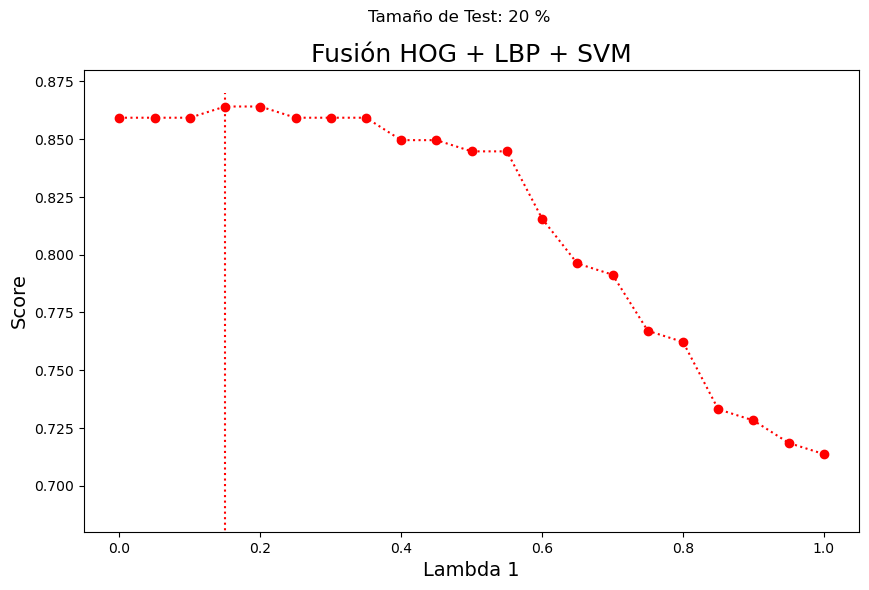

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(df_fusion2["Lambda 1"], df_fusion2["Score"], 'o:r')
plt.title('Fusión HOG + LBP + SVM', size=18)
plt.suptitle('Tamaño de Test: 20 %')

plt.ylim((0.68, 0.88))
plt.xlabel("Lambda 1", size=14)

plt.ylabel("Score", size=14)

indice_max2 = df_fusion2['Score'].idxmax()
lambda_max2 = df_fusion2['Lambda 1'][indice_max2]
plt.vlines(lambda_max2, 0.3, 0.87, linestyles='dotted', colors='red')
plt.show()

De esta manera obtenemos resultados más cercanos a los obtenidos en el paper y que mantienen la misma "dinámica", es decir, que el clasificador LBP resulta con mejor rendimiento y que aportando un poco del clasificador HOG (con un coeficiente aproximado de 0.2) obtenemos una leve mejoría general de la clasificación.

## Variación del tamaño de la celda en HOG y LBP

Buscando mejorar el rendimiento del modelo, pruebo modificar el tamaño de la celda para la extracción de los descriptores:  

Para el descriptor HOG, achico la celda a un tamaño de 4 x 4 pixels y mantengo los bloques de 2 x 2 celdas. Esto da como resultado un vector de features de dimensión 8100, bastante más grande que el anterior de dimensión 1764. Por ende el procesamiento se hizo bastante más lento pero mejoró la exactitud promedio, en un caso pasó de ~0.71 a ~0.76  

Con respecto al descriptor LBP, lo que mejor resultó luego de unas pruebas, fue agrandar la celda a 16 x 16 pixels, de esta manera el vector de features se achicó, pasó de una dimensión de 16384 a 4096, mejoró significativamente el tiempo de procesamiento y el rendimiento se mantuvo parecido.  

De esta manera pudimos mejorar el rendimiento de HOG con un poco más de tiempo de procesamiento, pero que en total no se hace mucho al mejorar el tiempo de procesamiento de LBP.  

Se obtiene así un rendimiento más parejo de los clasificadores y el punto de fusión óptimo está más cerca del 0.5, pero el rendimiento general es casi el mismo.



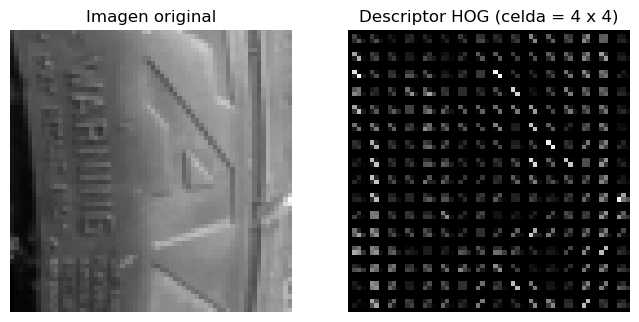

In [96]:
_ , hog_image = hog(img, orientations=9, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), block_norm='L2', transform_sqrt=True, visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.axis('off')
ax1.imshow(img, cmap='gray')
ax1.set_title('Imagen original')

ax2.axis('off')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('Descriptor HOG (celda = 4 x 4)')
plt.show()

A continuación se muestran los resultados:

In [97]:
X_HOG_4, y_HOG_4 = matrizHOG(dataset_total, 4, 2)
X_LBP_16, y_LBP_16 = matrizLBP(dataset_total, 16)

In [98]:
resultados_HOG_4 = calcula_scores(X_HOG_4, y_HOG_4, 10, 0.2)

 Exactitud 0 : 0.7621359223300971
 Exactitud 1 : 0.7475728155339806
 Exactitud 2 : 0.7135922330097088
 Exactitud 3 : 0.7961165048543689
 Exactitud 4 : 0.7718446601941747
 Exactitud 5 : 0.6941747572815534
 Exactitud 6 : 0.7378640776699029
 Exactitud 7 : 0.7912621359223301
 Exactitud 8 : 0.7135922330097088
 Exactitud 9 : 0.7378640776699029


In [381]:
print("Promedio HOG + SVM (Tamaño celda = 4): " + str(np.mean(resultados_HOG_4)))

Promedio HOG + SVM (Tamaño celda = 4): 0.733495145631068


In [384]:
resultados_LBP_16 = calcula_scores(X_LBP_16, y_LBP_16, kernel='linear')

 Exactitud 0 : 0.8592233009708737
 Exactitud 1 : 0.8300970873786407
 Exactitud 2 : 0.8398058252427184
 Exactitud 3 : 0.8349514563106796
 Exactitud 4 : 0.8446601941747572
 Exactitud 5 : 0.8592233009708737
 Exactitud 6 : 0.8398058252427184
 Exactitud 7 : 0.8786407766990292
 Exactitud 8 : 0.8203883495145631
 Exactitud 9 : 0.8446601941747572


In [385]:
print("Promedio LBP + SVM (Tamaño celda = 16): " + str(np.mean(resultados_LBP_16)))

Promedio LBP + SVM (Tamaño celda = 16): 0.8451456310679613


### Fusión

In [101]:
# Entrenamiento HOG + SVM
X_train_hog3, X_test_hog3, y_train_hog3, y_test_hog3 = train_test_split(X_HOG_4, y_HOG_4, test_size=0.2, random_state=0)

svc_hog3 = SVC(kernel='poly', degree=1, probability=True)
svc_hog3.fit(X_train_hog3, y_train_hog3)

# Predicción HOG + SVM
y_pred_hog3 = svc_hog3.predict_proba(X_test_hog3)

print(" Exactitud HOG + SVM (kernel polinomial grado 1): " + str(calcula_score(y_pred_hog3[:, 1], y_test_hog3)))

# Entrenamiento LBP + SVM
X_train_lbp3, X_test_lbp3, y_train_lbp3, y_test_lbp3 = train_test_split(X_LBP_16, y_LBP_16, test_size=0.2, random_state=0)

svc_lbp3 = SVC(kernel='linear', degree=2, probability=True)
svc_lbp3.fit(X_train_lbp3, y_train_lbp3)

# Predicción LBP + SVM
y_pred_lbp3 = svc_lbp3.predict_proba(X_test_lbp3)

print(" Exactitud LBP + SVM (kernel lineal): " + str(calcula_score(y_pred_lbp3[:, 1], y_test_lbp3)))

 Exactitud HOG + SVM (kernel polinomial grado 1): 0.7621359223300971
 Exactitud LBP + SVM (kernel lineal): 0.8252427184466019


In [104]:
tabla_fusion3 = calcula_fusion(y_pred_hog3[:, 1], y_pred_lbp3[:, 1], y_test_hog3)
df_fusion3 = pd.DataFrame(tabla_fusion3, columns=['Score', 'Lambda 1', 'Lambda 2'])

In [105]:
display(df_fusion3)

,Score,Lambda 1,Lambda 2
0,0.825243,0.00,1.00
1,0.825243,0.05,0.95
2,0.830097,0.10,0.90
3,0.825243,0.15,0.85
4,0.825243,0.20,0.80
5,0.834951,0.25,0.75
6,0.839806,0.30,0.70
7,0.844660,0.35,0.65
8,0.844660,0.40,0.60
9,0.849515,0.45,0.55


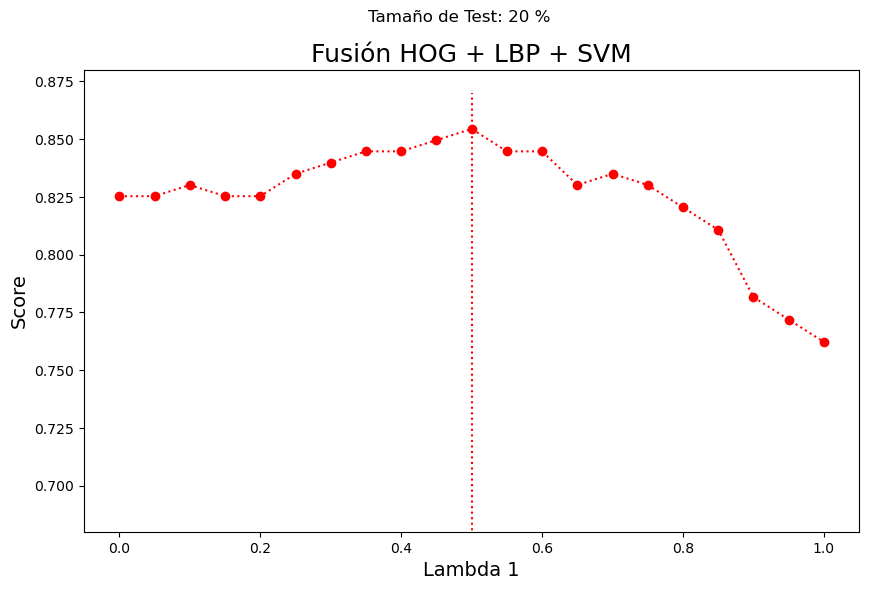

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(df_fusion3["Lambda 1"], df_fusion3["Score"], 'o:r')
plt.title('Fusión HOG + LBP + SVM', size=18)
plt.suptitle('Tamaño de Test: 20 %')

plt.ylim((0.68, 0.88))
plt.xlabel("Lambda 1", size=14)

plt.ylabel("Score", size=14)

indice_max3 = df_fusion3['Score'].idxmax()
lambda_max3 = df_fusion3['Lambda 1'][indice_max3]
plt.vlines(lambda_max3, 0.3, 0.87, linestyles='dotted', colors='red')
plt.show()

## Conclusiones

Leyendo el paper pude ir replicando los procesos y obteniendo resultados parecidos.  
 
Algunas cosas que no estaban del todo especificadas, como el tamaño de las celdas, me dieron lugar para experimentar un poco y obtener otros resultados interesantes.  

Pude reproducir el método y obtener similares conclusiones: 
 
En general el descriptor LBP tiene mejor exactitud que HOG para resolver la detección de fallas en neumáticos, pero que aportando un poco (del orden de 0.15 a 0.3) de la clasificación HOG podemos mejorar el rendimiento total de la clasificación.